In [90]:
import pandas as pd
# import numpy as np
from pathlib import Path
from definitions import ROOT_DIR
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rc, rc_context
import matplotlib
from seriate import seriate
from scipy.spatial.distance import pdist

matplotlib.rcParams['pdf.fonttype'] = 42
rc('font',**{'family':'sans-serif',
             'sans-serif':['Arial'],
             'size':12})

In [91]:
def get_class_size(metadata, class_column):
    sizes = metadata[class_column].value_counts()
    metadata['class_size'] = [sizes[k] for k in metadata[class_column]]
    return metadata


def filter_neutral_losses(df, neutral_losses=['']):
    '''
    Filter out entries for ions with neutral losses that are not in the list provided
    If neutral_loss value us "only_nl", than consider only ions that have neutral losses
    '''
    
    if neutral_losses == "only_nl":
        df = df[df.neutral_loss != ""]
    elif neutral_losses != None:
        df = df[df.neutral_loss.isin(neutral_losses)]
    return df


def filter_adducts(df, adducts=['']):
    '''
    Filter out entries for ions with adducts that are not in the list provided
    '''
    if adducts != None:
        df = df[df.adduct.isin(adducts)]
    return df


def filter_polarity(df, polarity=None):
    '''
    Filter out entries based on polarity pol ['positive', 'negative']
    '''
    if polarity != None:
        df = df[df.Polarity == polarity]
    return df


def filter_data(data, polarity=None, adducts=None, neutral_losses=None):
    '''
    Apply polarity, adduct and neutral_loss filters
    '''
    data = filter_polarity(data, polarity)
    data = filter_adducts(data, adducts)
    data = filter_neutral_losses(data, neutral_losses)
    return data


def group_by_molecule(df, groupby_columns):
    '''
    Aggregate intensity and detection values per groupby columns
    '''          
    data = df.groupby(groupby_columns).agg({
        'detectability' : 'max', # here detectability of metabolite is set to 1 if any of it's ions was detected
    }).reset_index()
    return data

In [92]:
p_root_dir = Path(ROOT_DIR)
p_data = p_root_dir / "data"
p_out = p_root_dir / "plots" / 'figure_5'
p_out.mkdir(exist_ok=True, parents=True)

# p_metadata = p_data / "Interlaboratory-All_metadata_19Apr2023.csv"

# Classification
p_chem_class = p_data / "custom_classification_v2.csv"

# Predictions
# p_predictions = p_data / "Interlaboratory-All_data_19Apr2023.csv"
# p_predictions = p_data / "Interlab_data_19Apr2023.csv"
p_predictions = p_data / "All_data_19Apr2023.csv"

In [93]:
# Load classification, add class size info

classes = pd.read_csv(p_chem_class, index_col='internal_id')
chem_class = get_class_size(classes[['name_short', 'main_coarse_class']].drop_duplicates(), 
                            'main_coarse_class')

# Load predictions and format neutral loss column
predictions = pd.read_csv(p_predictions) 
# [['dataset_id', 
#                                            'name_short', 
#                                            'adduct', 
#                                            'neutral_loss', 
#                                            'pred_val']]
predictions.neutral_loss.fillna('', inplace=True)

# # Add dataset metadata 
# metadata = pd.read_csv(p_metadata)
# metadata = metadata[metadata.Interlab]

In [94]:
predictions.columns

Index(['Sample name', 'Dataset name', 'Project', 'Participant lab',
       'Submitter', 'Technology', 'Original technology', 'Ionisation source',
       'Mass analyser', 'Source pressure', 'Matrix long', 'Matrix short',
       'Polarity', 'Slide code', 'dataset_id', 'name_short', 'formula',
       'adduct', 'neutral_loss', 'well', 'occupancy_ratio', 'on_off_ratio',
       'spot_occupancy', 'spot_occupancy_thresholded', 'image_occupancy',
       'other_spots_occupancy', 'bg_occupancy', 'far_bg_occupancy',
       'occupancy_vs_far_bg_ratio', 'in_n_spots', 'spot_intensity',
       'spot_intensity_bgr_corrected', 'spot_intensity_sum',
       'spot_intensity_std', 'other_spot_intensity', 'bg_intensity',
       'far_bg_intensity', 'intensity_vs_far_bg_ratio',
       'intensity_vs_other_spots_ratio', 'spot_intensity_tic_norm',
       'spot_intensity_bgr_corrected_tic_norm', 'spot_intensity_sum_tic_norm',
       'spot_intensity_std_tic_norm', 'other_spot_intensity_tic_norm',
       'bg_intensi

In [95]:
# # Merge with predictions
# df = pd.merge(metadata, predictions, right_on='dataset_id', left_on='Dataset ID', how='left')
df=predictions

# # Only consider data of detected ions
threshold = 0.8
df['detectability'] = df.pred_val >= threshold
data = df[df.detectability]

# Interlaboratory comparison heatmap

In [78]:
def summarise_per_class(df):
    
    data = df.pivot_table(index=['Sample name', 'main_coarse_class'],
                      values=['detectability', 'class_size'],
                      aggfunc = {
                                'class_size':'first',
                                'detectability':'sum'
                                }).reset_index()

    data['fraction_detected'] = data.detectability / data.class_size 
    data.drop(columns=['detectability', 'class_size'], inplace=True)
    
    return data

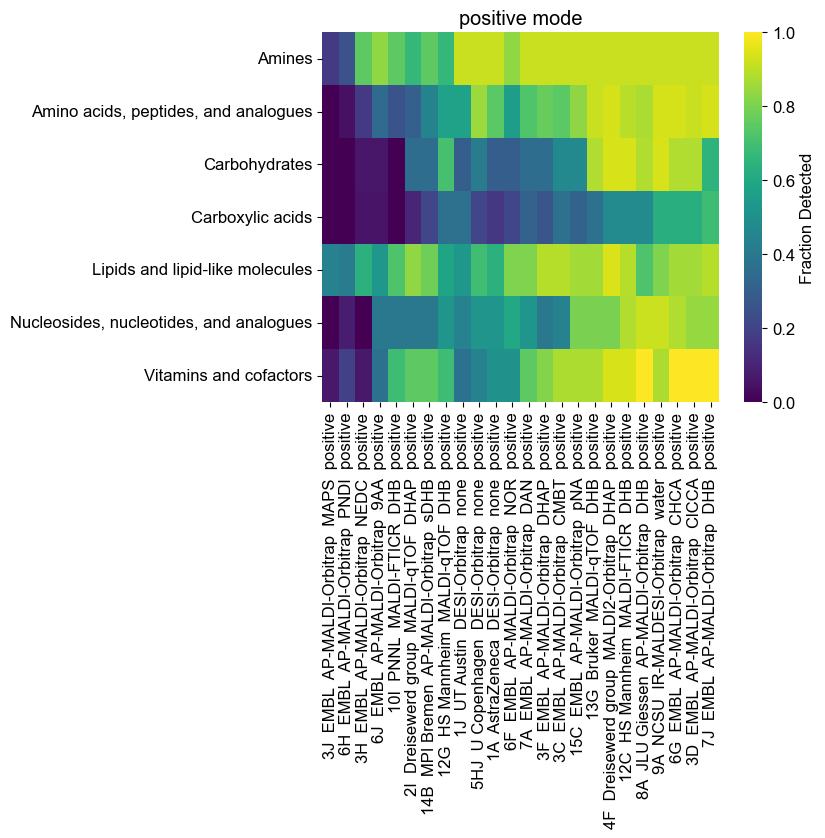

In [79]:
for polarity in ['positive']:#, 'negative'
    
    # Choose polarity, filter adducts and neutral losses
    filtered_data = filter_data(data,
                                polarity=polarity, 
                                neutral_losses=[''])
    
    # Summarise data per metabolite and dataset
    molecule_data = group_by_molecule(filtered_data, groupby_columns=['Sample name', 'name_short'])

    # Map chemical class to the metabolite
    mapped_data = molecule_data.merge(chem_class, on='name_short', how='left')

    # Summarise data per class (mean of detected metabolites, and fraction of detected ions per class)
    class_data = summarise_per_class(mapped_data)
    
    # Prepare data for plotting
    plot_data = class_data.pivot_table(index = 'Sample name',
                                       columns='main_coarse_class',
                                       values='fraction_detected',
                                       fill_value=0)

    # Change row order by seriation
    new_row_order = seriate(pdist(plot_data.to_numpy()))
    new_index = plot_data.index[new_row_order]
    plot_data = plot_data.reindex(index=new_index).T

    # Plot
    fname = f"heatmap_interlab_{polarity}"
    ax = sns.heatmap(data=plot_data, 
                    cmap='viridis',
                    cbar_kws={'label': 'Fraction Detected'},
                    xticklabels=True)
    ax.set(title=f"{polarity} mode", xlabel="", ylabel="")#, aspect=1)
#     plt.savefig(p_out / f"{fname}.png")
#     plt.savefig(p_out/ f"{fname}.pdf", transparent=True)
#     plt.close()

In [89]:
import json

with open(r"D:\saharuka\spotting\spotting_git\interlaboratory_comparison\test\test_may2.json") as f:
    d = json.load(f)

app = pd.DataFrame([(x['Sample name'], x['main_coarse_class'], x['fraction_detected'])for x in d['body']['data']], columns=['sample_name', 'main_coarse_class', 'fraction_detected'])

app.pivot(index='main_coarse_class', columns='sample_name', values='fraction_detected')

sample_name,10I PNNL MALDI-FTICR DHB positive,12C HS Mannheim MALDI-FTICR DHB positive,12G HS Mannheim MALDI-qTOF DHB positive,13G Bruker MALDI-qTOF DHB positive,14B MPI Bremen AP-MALDI-Orbitrap sDHB positive,1A AstraZeneca DESI-Orbitrap none positive,1J UT Austin DESI-Orbitrap none positive,2I Dreisewerd group MALDI-qTOF DHAP positive,4F Dreisewerd group MALDI2-Orbitrap DHAP positive,5HJ U Copenhagen DESI-Orbitrap none positive,7J EMBL AP-MALDI-Orbitrap DHB positive,8A JLU Giessen AP-MALDI-Orbitrap DHB positive,9A NCSU IR-MALDESI-Orbitrap water positive
main_coarse_class,,,,,,,,,,,,,
Amines,0.750000,0.916667,0.666667,0.916667,0.750000,0.916667,0.916667,0.666667,0.916667,0.916667,0.916667,0.916667,0.916667
"Amino acids, peptides, and analogues",0.255319,0.893617,0.574468,0.914894,0.446809,0.744681,0.574468,0.297872,0.936170,0.851064,0.936170,0.872340,0.936170
Carbohydrates,NaN,0.941176,0.705882,0.882353,0.352941,0.294118,0.294118,0.352941,0.941176,0.411765,0.647059,0.882353,0.941176
Carboxylic acids,NaN,0.473684,0.368421,0.368421,0.210526,0.157895,0.368421,0.105263,0.473684,0.210526,0.684211,0.473684,0.631579
Lipids and lipid-like molecules,0.722222,0.888889,0.583333,0.861111,0.777778,0.638889,0.527778,0.833333,0.944444,0.694444,0.888889,0.722222,0.805556
"Nucleosides, nucleotides, and analogues",0.400000,0.880000,0.520000,0.800000,0.400000,0.520000,0.440000,0.400000,0.800000,0.520000,0.840000,0.920000,0.920000
Vitamins and cofactors,0.687500,0.937500,0.687500,0.875000,0.750000,0.500000,0.375000,0.750000,0.937500,0.437500,1.000000,1.000000,0.875000


In [58]:
plot_data[[
           '10I  PNNL  MALDI-FTICR  DHB  positive',
           '12C  HS Mannheim  MALDI-FTICR  DHB  positive',
           '12G  HS Mannheim  MALDI-qTOF  DHB  positive',
      '13G  Bruker  MALDI-qTOF  DHB  positive',
         '14B  MPI Bremen  AP-MALDI-Orbitrap  sDHB  positive',
           '1A  AstraZeneca  DESI-Orbitrap  none  positive',
       '1J  UT Austin  DESI-Orbitrap  none  positive',
       '2I  Dreisewerd group  MALDI-qTOF  DHAP  positive',
       '4F  Dreisewerd group  MALDI2-Orbitrap  DHAP  positive',
       '5HJ  U Copenhagen  DESI-Orbitrap  none  positive',
    '7J  EMBL  AP-MALDI-Orbitrap  DHB  positive',
       '8A  JLU Giessen  AP-MALDI-Orbitrap  DHB  positive',
           '9A  NCSU  IR-MALDESI-Orbitrap  water  positive',
]]

Sample name,10I PNNL MALDI-FTICR DHB positive,12C HS Mannheim MALDI-FTICR DHB positive,12G HS Mannheim MALDI-qTOF DHB positive,13G Bruker MALDI-qTOF DHB positive,14B MPI Bremen AP-MALDI-Orbitrap sDHB positive,1A AstraZeneca DESI-Orbitrap none positive,1J UT Austin DESI-Orbitrap none positive,2I Dreisewerd group MALDI-qTOF DHAP positive,4F Dreisewerd group MALDI2-Orbitrap DHAP positive,5HJ U Copenhagen DESI-Orbitrap none positive,7J EMBL AP-MALDI-Orbitrap DHB positive,8A JLU Giessen AP-MALDI-Orbitrap DHB positive,9A NCSU IR-MALDESI-Orbitrap water positive
main_coarse_class,,,,,,,,,,,,,
Amines,0.750000,0.916667,0.666667,0.916667,0.750000,0.916667,0.916667,0.666667,0.916667,0.916667,0.916667,0.916667,0.916667
"Amino acids, peptides, and analogues",0.255319,0.893617,0.574468,0.914894,0.446809,0.744681,0.574468,0.297872,0.936170,0.851064,0.936170,0.872340,0.936170
Carbohydrates,0.000000,0.941176,0.705882,0.882353,0.352941,0.294118,0.294118,0.352941,0.941176,0.411765,0.647059,0.882353,0.941176
Carboxylic acids,0.000000,0.473684,0.368421,0.368421,0.210526,0.157895,0.368421,0.105263,0.473684,0.210526,0.684211,0.473684,0.631579
Lipids and lipid-like molecules,0.722222,0.888889,0.583333,0.861111,0.777778,0.638889,0.527778,0.833333,0.944444,0.694444,0.888889,0.722222,0.805556
"Nucleosides, nucleotides, and analogues",0.400000,0.880000,0.520000,0.800000,0.400000,0.520000,0.440000,0.400000,0.800000,0.520000,0.840000,0.920000,0.920000
Vitamins and cofactors,0.687500,0.937500,0.687500,0.875000,0.750000,0.500000,0.375000,0.750000,0.937500,0.437500,1.000000,1.000000,0.875000
